In [2]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
# Training data is 100 points in [0,1] inclusive regularly spaced
train_x = torch.linspace(0, 1, 100)
# True function is sin(2*pi*x) with Gaussian noise
train_y = torch.sin(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * math.sqrt(0.04)

In [8]:
train_y.shape

torch.Size([100])

In [4]:
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
    
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)

In [7]:
# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iter = 2 if smoke_test else 10


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    print(train_y.shape)
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model.covar_module.base_kernel.lengthscale.item(),
        model.likelihood.noise.item()
    ))
    optimizer.step()

torch.Size([100])
Iter 1/10 - Loss: 0.186   lengthscale: 0.278   noise: 0.126
torch.Size([100])
Iter 2/10 - Loss: 0.159   lengthscale: 0.255   noise: 0.115
torch.Size([100])
Iter 3/10 - Loss: 0.133   lengthscale: 0.266   noise: 0.105
torch.Size([100])
Iter 4/10 - Loss: 0.109   lengthscale: 0.278   noise: 0.095
torch.Size([100])
Iter 5/10 - Loss: 0.087   lengthscale: 0.276   noise: 0.087
torch.Size([100])
Iter 6/10 - Loss: 0.067   lengthscale: 0.269   noise: 0.079
torch.Size([100])
Iter 7/10 - Loss: 0.049   lengthscale: 0.263   noise: 0.072
torch.Size([100])
Iter 8/10 - Loss: 0.035   lengthscale: 0.262   noise: 0.065
torch.Size([100])
Iter 9/10 - Loss: 0.024   lengthscale: 0.267   noise: 0.060
torch.Size([100])
Iter 10/10 - Loss: 0.015   lengthscale: 0.274   noise: 0.055


In [9]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(0, 1, 51)
    observed_pred = likelihood(model(test_x))

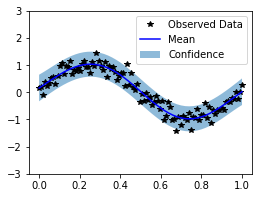

In [10]:
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(4, 3))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(test_x.numpy(), observed_pred.mean.numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])

In [7]:
a=[[[0, 1, 1, 11.532728092266408, 0.0, 0.4458039, 0, 0, 0, 1, 0, 5.298317366548036, 4.605170185988092], [0, 1, 1, 11.532728092266408, 0.0, 0.4458039, 0, 0, 1, 0, 0, 5.298317366548036, 7.9996785794994505], [0, 1, 1, 11.532728092266408, 0.0, 0.4458039, 0, 0, 0, 1, 0, 5.424950017481403, 8.252185436003328], [0, 1, 1, 11.532728092266408, 0.0, 0.4458039, 0, 0, 1, 0, 0, 4.8283137373023015, 7.608374474380783], [0, 1, 1, 11.532728092266408, 0.0, 0.4458039, 0, 0, 1, 0, 0, 3.9512437185814275, 6.51025834052315], [0, 1, 1, 11.532728092266408, 0.0, 0.4458039, 0, 0, 0, 0, 1, 3.9512437185814275, 6.775366090936392], [0, 1, 1, 11.532728092266408, 0.0, 0.4458039, 0, 0, 0, 1, 0, 6.20455776256869, 9.184099060770956], [0, 1, 1, 11.532728092266408, 0.0, 0.4458039, 0, 0, 0, 1, 0, 8.474494436883122, 8.480321716640333], [0, 1, 1, 11.532728092266408, 0.0, 0.4458039, 0, 0, 1, 0, 0, 4.219507705176107, 7.106606137727303], [0, 1, 1, 11.532728092266408, 0.0, 0.4458039, 0, 0, 1, 0, 0, 3.332204510175204, 6.008813185442595], [0, 1, 1, 11.532728092266408, 0.0, 0.4458039, 0, 0, 0, 0, 1, 3.332204510175204, 6.159095388491933], [0, 1, 1, 11.532728092266408, 0.0, 0.4458039, 0, 0, 0, 1, 0, 5.598421958998375, 8.517793011488205], [0, 1, 1, 11.532728092266408, 0.0, 0.4458039, 0, 0, 0, 1, 0, 8.474494436883122, 8.480321716640333], [0, 1, 1, 11.532728092266408, 0.0, 0.4458039, 0, 0, 1, 0, 0, 3.5263605246161616, 6.398594934535208], [0, 1, 1, 11.532728092266408, 0.0, 0.4458039, 0, 0, 0, 1, 0, 3.5263605246161616, 6.492239835020471], [0, 1, 1, 11.532728092266408, 0.0, 0.4458039, 0, 0, 0, 0, 1, 3.5263605246161616, 6.492239835020471], [0, 1, 1, 11.532728092266408, 0.0023666667, 0.0009019607843137254, 1, 0, 0, 0, 0, 8.474494436883122, 8.480321716640333], [0, 1, 1, 11.532728092266408, 0.0023666667, 0.0009019607843137254, 1, 0, 0, 0, 0, 8.474494436883122, 8.480321716640333], [0, 1, 1, 11.532728092266408, 0.0023666667, 0.0009019607843137254, 1, 0, 0, 0, 0, 8.474494436883122, 8.480321716640333], [1, 0, 0, 11.198885727831211, 0.0, 0.0027378882667798326, 1, 0, 0, 0, 0, 2.8903717578961645, 3.4339872044851463], [1, 0, 0, 11.198885727831211, 0.0, 0.0027378882667798326, 1, 0, 0, 0, 0, 2.8903717578961645, 3.4339872044851463], [1, 0, 0, 11.198885727831211, 0.0, 0.0027378882667798326, 1, 0, 0, 0, 0, 2.8903717578961645, 3.4339872044851463], [1, 0, 0, 17.175920388957422, 0.047133334, 6.329643090071342e-05, 0, 0, 0, 0, 1, 8.454466361507933, 11.408875201667874]], 0.051231650722236406]

In [8]:
for i in a[0]:
    print(i)

[0, 1, 1, 11.532728092266408, 0.0, 0.4458039, 0, 0, 0, 1, 0, 5.298317366548036, 4.605170185988092]
[0, 1, 1, 11.532728092266408, 0.0, 0.4458039, 0, 0, 1, 0, 0, 5.298317366548036, 7.9996785794994505]
[0, 1, 1, 11.532728092266408, 0.0, 0.4458039, 0, 0, 0, 1, 0, 5.424950017481403, 8.252185436003328]
[0, 1, 1, 11.532728092266408, 0.0, 0.4458039, 0, 0, 1, 0, 0, 4.8283137373023015, 7.608374474380783]
[0, 1, 1, 11.532728092266408, 0.0, 0.4458039, 0, 0, 1, 0, 0, 3.9512437185814275, 6.51025834052315]
[0, 1, 1, 11.532728092266408, 0.0, 0.4458039, 0, 0, 0, 0, 1, 3.9512437185814275, 6.775366090936392]
[0, 1, 1, 11.532728092266408, 0.0, 0.4458039, 0, 0, 0, 1, 0, 6.20455776256869, 9.184099060770956]
[0, 1, 1, 11.532728092266408, 0.0, 0.4458039, 0, 0, 0, 1, 0, 8.474494436883122, 8.480321716640333]
[0, 1, 1, 11.532728092266408, 0.0, 0.4458039, 0, 0, 1, 0, 0, 4.219507705176107, 7.106606137727303]
[0, 1, 1, 11.532728092266408, 0.0, 0.4458039, 0, 0, 1, 0, 0, 3.332204510175204, 6.008813185442595]
[0, 1, 1

In [9]:
a[1]

0.051231650722236406